# Adam --- 从0开始

Adam是一个组合了[动量法](momentum-scratch.md)和[RMSProp](rmsprop-scratch.md)的优化算法。



## Adam算法

Adam算法会使用一个动量变量$\mathbf{v}$和一个RMSProp中梯度按元素平方的指数加权移动平均变量$\mathbf{s}$，并将它们中每个元素初始化为0。在每次迭代中，首先计算[小批量梯度](gd-sgd-scratch.md) $\mathbf{g}$，并递增迭代次数

$$t := t + 1$$

然后对梯度做指数加权移动平均并计算动量变量$\mathbf{v}$:

$$\mathbf{v} := \beta_1 \mathbf{v} + (1 - \beta_1) \mathbf{g} $$


该梯度按元素平方后做指数加权移动平均并计算$\mathbf{s}$：

$$\mathbf{s} := \beta_2 \mathbf{s} + (1 - \beta_2) \mathbf{g} \odot \mathbf{g} $$


在Adam算法里，为了减轻$\mathbf{v}$和$\mathbf{s}$被初始化为0在迭代初期对计算指数加权移动平均的影响，我们做下面的偏差修正：

$$\hat{\mathbf{v}} := \frac{\mathbf{v}}{1 - \beta_1^t} $$

和

$$\hat{\mathbf{s}} := \frac{\mathbf{s}}{1 - \beta_2^t} $$



可以看到，当$0 \leq \beta_1, \beta_2 < 1$时（算法作者建议分别设为0.9和0.999），当迭代后期$t$较大时，偏差修正几乎就不再有影响。我们使用以上偏差修正后的动量变量和RMSProp中梯度按元素平方的指数加权移动平均变量，将模型参数中每个元素的学习率通过按元素操作重新调整一下：

$$\mathbf{g}^\prime := \frac{\eta \hat{\mathbf{v}}}{\sqrt{\hat{\mathbf{s}} + \epsilon}} $$

其中$\eta$是初始学习率，$\epsilon$是为了维持数值稳定性而添加的常数，例如$10^{-8}$。和Adagrad一样，模型参数中每个元素都分别拥有自己的学习率。

同样地，最后的参数迭代步骤与小批量随机梯度下降类似。只是这里梯度前的学习率已经被调整过了：

$$\mathbf{x} := \mathbf{x} - \mathbf{g}^\prime $$


## Adam的实现


Adam的实现很简单。我们只需要把上面的数学公式翻译成代码。

In [1]:
# Adam。
def adam(params, vs, sqrs, lr, batch_size, t):
    beta1 = 0.9
    beta2 = 0.999
    eps_stable = 1e-8
    for param, v, sqr in zip(params, vs, sqrs):      
        g = param.grad / batch_size
        v[:] = beta1 * v + (1. - beta1) * g
        sqr[:] = beta2 * sqr + (1. - beta2) * nd.square(g)
        v_bias_corr = v / (1. - beta1 ** t)
        sqr_bias_corr = sqr / (1. - beta2 ** t)
        div = lr * v_bias_corr / (nd.sqrt(sqr_bias_corr) + eps_stable)        
        param[:] = param - div

## 实验

实验中，我们以线性回归为例。其中真实参数`w`为[2, -3.4]，`b`为4.2。我们把算法中基于指数加权移动平均的变量初始化为和参数形状相同的零张量。

In [2]:
import mxnet as mx
from mxnet import autograd
from mxnet import ndarray as nd
from mxnet import gluon
import random

mx.random.seed(1)
random.seed(1)

# 生成数据集。
num_inputs = 2
num_examples = 1000
true_w = [2, -3.4]
true_b = 4.2
X = nd.random_normal(scale=1, shape=(num_examples, num_inputs))
y = true_w[0] * X[:, 0] + true_w[1] * X[:, 1] + true_b
y += .01 * nd.random_normal(scale=1, shape=y.shape)
dataset = gluon.data.ArrayDataset(X, y)

# 构造迭代器。
import random
def data_iter(batch_size):
    idx = list(range(num_examples))
    random.shuffle(idx)
    for batch_i, i in enumerate(range(0, num_examples, batch_size)):
        j = nd.array(idx[i: min(i + batch_size, num_examples)])
        yield batch_i, X.take(j), y.take(j)

# 初始化模型参数。
def init_params():
    w = nd.random_normal(scale=1, shape=(num_inputs, 1))
    b = nd.zeros(shape=(1,))
    params = [w, b]
    vs = []
    sqrs = []
    for param in params:
        param.attach_grad()
        # 把算法中基于指数加权移动平均的变量初始化为和参数形状相同的零张量。
        vs.append(param.zeros_like())
        sqrs.append(param.zeros_like())
    return params, vs, sqrs

# 线性回归模型。
def net(X, w, b):
    return nd.dot(X, w) + b

# 损失函数。
def square_loss(yhat, y):
    return (yhat - y.reshape(yhat.shape)) ** 2 / 2

接下来定义训练函数。当epoch大于2时（epoch从1开始计数），学习率以自乘0.1的方式自我衰减。训练函数的period参数说明，每次采样过该数目的数据点后，记录当前目标函数值用于作图。例如，当period和batch_size都为10时，每次迭代后均会记录目标函数值。

In [3]:
%matplotlib inline
import matplotlib as mpl
mpl.rcParams['figure.dpi']= 120
import matplotlib.pyplot as plt
import numpy as np

def train(batch_size, lr, epochs, period):
    assert period >= batch_size and period % batch_size == 0
    [w, b], vs, sqrs = init_params()
    total_loss = [np.mean(square_loss(net(X, w, b), y).asnumpy())]

    # 注意epoch从1开始计数。
    t = 0
    for epoch in range(1, epochs + 1):
        for batch_i, data, label in data_iter(batch_size):
            with autograd.record():
                output = net(data, w, b)
                loss = square_loss(output, label)
            loss.backward()
            # 必须在调用Adam前。
            t += 1
            adam([w, b], vs, sqrs, lr, batch_size, t)
            if batch_i * batch_size % period == 0:
                total_loss.append(np.mean(square_loss(net(X, w, b), y).asnumpy()))
        print("Batch size %d, Learning rate %f, Epoch %d, loss %.4e" % 
              (batch_size, lr, epoch, total_loss[-1]))
    print('w:', np.reshape(w.asnumpy(), (1, -1)), 
          'b:', b.asnumpy()[0], '\n')
    x_axis = np.linspace(0, epochs, len(total_loss), endpoint=True)
    plt.semilogy(x_axis, total_loss)
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.show()

使用Adam，最终学到的参数值与真实值较接近。

Batch size 10, Learning rate 0.100000, Epoch 1, loss 8.4512e-04


Batch size 10, Learning rate 0.100000, Epoch 2, loss 5.1735e-05


Batch size 10, Learning rate 0.100000, Epoch 3, loss 4.9982e-05
w: [[ 2.00149035 -3.40016317]] b: 4.20201 



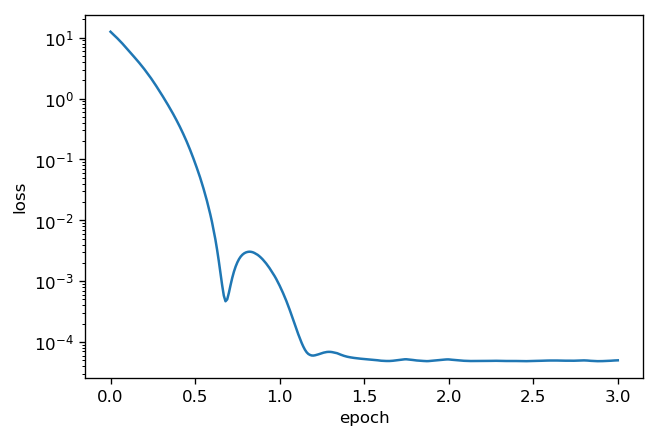

In [4]:
train(batch_size=10, lr=0.1, epochs=3, period=10)

## 结论

* Adam组合了动量法和RMSProp。


## 练习

* 你是怎样理解Adam算法中的偏差修正项的？

**吐槽和讨论欢迎点**[这里](https://discuss.gluon.ai/t/topic/2279)